/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 30])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([2, 30])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_lo

Epoch [1/50], Train Loss: 0.0530, Val Loss: 0.0633, MAPE: inf%, MAE: 0.2115, RMSE: 0.2499
Epoch [2/50], Train Loss: 0.0454, Val Loss: 0.0629, MAPE: inf%, MAE: 0.2090, RMSE: 0.2491
Epoch [3/50], Train Loss: 0.0451, Val Loss: 0.0627, MAPE: inf%, MAE: 0.2049, RMSE: 0.2487
Epoch [4/50], Train Loss: 0.0452, Val Loss: 0.0628, MAPE: inf%, MAE: 0.2038, RMSE: 0.2489
Epoch [5/50], Train Loss: 0.0452, Val Loss: 0.0628, MAPE: inf%, MAE: 0.2084, RMSE: 0.2489
Epoch [6/50], Train Loss: 0.0450, Val Loss: 0.0627, MAPE: inf%, MAE: 0.2052, RMSE: 0.2487
Epoch [7/50], Train Loss: 0.0455, Val Loss: 0.0632, MAPE: inf%, MAE: 0.2018, RMSE: 0.2498
Epoch [8/50], Train Loss: 0.0453, Val Loss: 0.0630, MAPE: inf%, MAE: 0.2025, RMSE: 0.2494
Epoch [9/50], Train Loss: 0.0453, Val Loss: 0.0628, MAPE: inf%, MAE: 0.2081, RMSE: 0.2489
Epoch [10/50], Train Loss: 0.0450, Val Loss: 0.0630, MAPE: inf%, MAE: 0.2026, RMSE: 0.2493
Epoch [11/50], Train Loss: 0.0451, Val Loss: 0.0627, MAPE: inf%, MAE: 0.2057, RMSE: 0.2486
Epoch [1

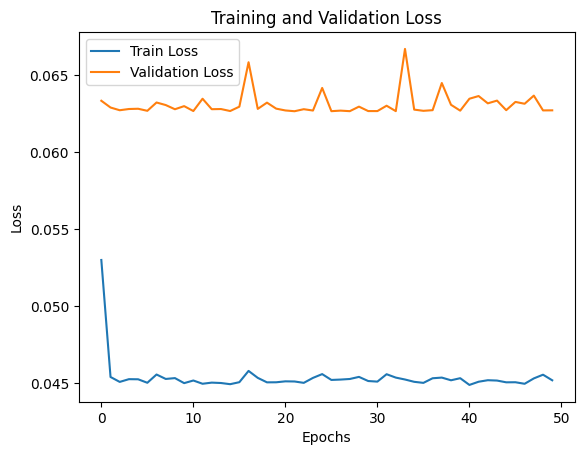

Test Loss: 0.0531, MAPE: inf%, MAE: 0.1957, RMSE: 0.2288


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([20, 30])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('JSE_clean_truncated.csv').values  # Load your dataset
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, input_window, horizon):
    xs, ys = [], []
    for i in range(len(data) - input_window - horizon + 1):
        x = data[i:i + input_window]
        y = data[i + input_window + horizon - 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_window = 30
horizon = 5
X, y = create_sequences(normalized_data, input_window, horizon)

# Train-validation-test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Graph Structure (using a correlation matrix as an adjacency matrix)
adj_matrix = np.corrcoef(normalized_data.T)  # Create adjacency matrix based on correlation
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)

# Define the StemGNN Model
class StemGNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, adj_matrix, time_steps):
        super(StemGNN, self).__init__()
        self.adj_matrix = adj_matrix
        self.time_steps = time_steps
        self.gcn = nn.Linear(input_dim * num_nodes, hidden_dim)  # Adjusting input_dim
        self.temporal_conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim * time_steps, output_dim)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)

        # Matrix multiplication with the adjacency matrix
        x = torch.einsum('ncvl,vw->ncwl', (x, self.adj_matrix))

        batch_size, num_channels, num_nodes, time_steps = x.shape
        x = x.reshape(batch_size, -1)  # Flatten for GCN

        x = torch.relu(self.gcn(x))

        # Reshaping into [batch_size, hidden_dim, time_steps] for Conv1D
        x = x.view(batch_size, 64, 1)  # Adjust to have 1 time step

        x = self.temporal_conv(x)
        x = torch.relu(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# Evaluation metrics
def compute_metrics(y_true, y_pred):
    mae = nn.L1Loss()(y_true, y_pred).item()  # Mean Absolute Error
    rmse = torch.sqrt(nn.MSELoss()(y_true, y_pred)).item()  # Root Mean Square Error
    mape = (torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100).item()  # Mean Absolute Percentage Error
    return mape, mae, rmse

# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses = []
    val_losses = []
    val_metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        mape_total, mae_total, rmse_total = 0.0, 0.0, 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch)
                loss = criterion(y_val_pred, y_val_batch)
                val_loss += loss.item()

                # Compute evaluation metrics
                mape, mae, rmse = compute_metrics(y_val_batch, y_val_pred)
                mape_total += mape
                mae_total += mae
                rmse_total += rmse

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_metrics.append({
            'mape': mape_total / len(val_loader),
            'mae': mae_total / len(val_loader),
            'rmse': rmse_total / len(val_loader)
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'MAPE: {mape_total/len(val_loader):.2f}%, MAE: {mae_total/len(val_loader):.4f}, RMSE: {rmse_total/len(val_loader):.4f}')

    return train_losses, val_losses, val_metrics

# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_nodes = 30
input_dim = 30  # Based on your input
hidden_dim = 64
output_dim = 1
time_steps = 1
adj_matrix = torch.randn(num_nodes, num_nodes)  # Example adjacency matrix

model = StemGNN(num_nodes, input_dim, hidden_dim, output_dim, adj_matrix.to(device), time_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training the model
train_losses, val_losses, val_metrics = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50)

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    mape_total, mae_total, rmse_total = 0.0, 0.0, 0.0
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_test_pred = model(X_test_batch)
            loss = criterion(y_test_pred, y_test_batch)
            test_loss += loss.item()

            # Compute evaluation metrics
            mape, mae, rmse = compute_metrics(y_test_batch, y_test_pred)
            mape_total += mape
            mae_total += mae
            rmse_total += rmse

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}, MAPE: {mape_total/len(test_loader):.2f}%, '
          f'MAE: {mae_total/len(test_loader):.4f}, RMSE: {rmse_total/len(test_loader):.4f}')

# Evaluate on test set
evaluate_model(model, test_loader, criterion)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess the dataset
data = pd.read_csv('JSE_clean_truncated.csv').values  # Load your dataset
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, input_window, horizon):
    xs, ys = [], []
    for i in range(len(data) - input_window - horizon + 1):
        x = data[i:i + input_window]
        y = data[i + input_window + horizon - 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the StemGNN Model
class StemGNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, adj_matrix, time_steps):
        super(StemGNN, self).__init__()
        self.adj_matrix = adj_matrix
        self.time_steps = time_steps
        self.gcn = nn.Linear(input_dim * num_nodes, hidden_dim)  # Adjusting input_dim
        self.temporal_conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim * time_steps, output_dim)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)

        # Matrix multiplication with the adjacency matrix
        x = torch.einsum('ncvl,vw->ncwl', (x, self.adj_matrix))

        batch_size, num_channels, num_nodes, time_steps = x.shape
        x = x.reshape(batch_size, -1)  # Flatten for GCN

        x = torch.relu(self.gcn(x))

        # Reshaping into [batch_size, hidden_dim, time_steps] for Conv1D
        x = x.view(batch_size, 64, 1)  # Adjust to have 1 time step

        x = self.temporal_conv(x)
        x = torch.relu(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# Evaluation metrics
def compute_metrics(y_true, y_pred):
    mae = nn.L1Loss()(y_true, y_pred).item()  # Mean Absolute Error
    rmse = torch.sqrt(nn.MSELoss()(y_true, y_pred)).item()  # Root Mean Square Error
    mape = (torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-8))) * 100).item()  # Mean Absolute Percentage Error with zero handling
    return mape, mae, rmse

# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50):
    train_losses = []
    val_losses = []
    val_metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        mape_total, mae_total, rmse_total = 0.0, 0.0, 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch)
                loss = criterion(y_val_pred, y_val_batch)
                val_loss += loss.item()

                # Compute evaluation metrics
                mape, mae, rmse = compute_metrics(y_val_batch, y_val_pred)
                mape_total += mape
                mae_total += mae
                rmse_total += rmse

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_metrics.append({
            'mape': mape_total / len(val_loader),
            'mae': mae_total / len(val_loader),
            'rmse': rmse_total / len(val_loader)
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'MAPE: {mape_total/len(val_loader):.2f}%, MAE: {mae_total/len(val_loader):.4f}, RMSE: {rmse_total/len(val_loader):.4f}')

    return train_losses, val_losses, val_metrics

# Evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    mape_total, mae_total, rmse_total = 0.0, 0.0, 0.0
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_test_pred = model(X_test_batch)
            loss = criterion(y_test_pred, y_test_batch)
            test_loss += loss.item()

            # Compute evaluation metrics
            mape, mae, rmse = compute_metrics(y_test_batch, y_test_pred)
            mape_total += mape
            mae_total += mae
            rmse_total += rmse

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}, MAPE: {mape_total/len(test_loader):.2f}%, '
          f'MAE: {mae_total/len(test_loader):.4f}, RMSE: {rmse_total/len(test_loader):.4f}')
    return mape_total/len(test_loader), mae_total/len(test_loader), rmse_total/len(test_loader)

# Hyperparameter Configurations
hyperparameter_configurations = [
    {'input_window': 30, 'output_window': 1, 'hidden_nodes': 64, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100},
    {'input_window': 30, 'output_window': 5, 'hidden_nodes': 64, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100},
]

# Run experiments
results = []

for config in hyperparameter_configurations:
    print(f"Training with config: {config}")

    # Create sequences based on the current configuration
    X, y = create_sequences(normalized_data, config['input_window'], config['output_window'])

    # Train-validation-test split
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    test_size = len(X) - train_size - val_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Convert to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model, optimizer, and criterion
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_nodes = X_train.shape[1]
    input_dim = X_train.shape[2]
    hidden_dim = config['hidden_nodes']
    output_dim = 1
    adj_matrix = torch.randn(num_nodes, num_nodes)  # Example adjacency matrix

    riterion = nn.MSELoss()

    # Train the model
    train_losses, val_losses, val_metrics = train_model(
        model, train_loader, val_loader, optimizer, criterion, num_epochs=config['epochs']
    )

    # Evaluate the model on the test set
    mape, mae, rmse = evaluate_model(model, test_loader, criterion)

    # Store the results for this configuration
    results.append({
        'config': config,
        'mape': mape,
        'mae': mae,
        'rmse': rmse,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_metrics': val_metrics
    })

# After all configurations
for result in results:
    config = result['config']
    print(f"Results for config: {config}")
    print(f"Test MAPE: {result['mape']:.4f}%")
    print(f"Test MAE: {result['mae']:.4f}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print("-" * 50)

Training with config: {'input_window': 30, 'output_window': 1, 'hidden_nodes': 64, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 30])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([5, 30])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_lo

Epoch [1/100], Train Loss: 0.0450, Val Loss: 0.0626, MAPE: 407021.17%, MAE: 0.2070, RMSE: 0.2486
Epoch [2/100], Train Loss: 0.0450, Val Loss: 0.0626, MAPE: 407506.79%, MAE: 0.2068, RMSE: 0.2486
Epoch [3/100], Train Loss: 0.0450, Val Loss: 0.0627, MAPE: 402652.39%, MAE: 0.2083, RMSE: 0.2488
Epoch [4/100], Train Loss: 0.0450, Val Loss: 0.0626, MAPE: 406388.89%, MAE: 0.2071, RMSE: 0.2486
Epoch [5/100], Train Loss: 0.0449, Val Loss: 0.0628, MAPE: 401376.63%, MAE: 0.2087, RMSE: 0.2489
Epoch [6/100], Train Loss: 0.0449, Val Loss: 0.0628, MAPE: 399450.77%, MAE: 0.2092, RMSE: 0.2490
Epoch [7/100], Train Loss: 0.0450, Val Loss: 0.0628, MAPE: 399506.82%, MAE: 0.2092, RMSE: 0.2490
Epoch [8/100], Train Loss: 0.0451, Val Loss: 0.0626, MAPE: 405179.02%, MAE: 0.2074, RMSE: 0.2486
Epoch [9/100], Train Loss: 0.0450, Val Loss: 0.0627, MAPE: 402162.10%, MAE: 0.2083, RMSE: 0.2488
Epoch [10/100], Train Loss: 0.0449, Val Loss: 0.0627, MAPE: 403305.80%, MAE: 0.2079, RMSE: 0.2487
Epoch [11/100], Train Loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([20, 30])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_

Epoch [1/100], Train Loss: 0.0452, Val Loss: 0.0627, MAPE: 413584.44%, MAE: 0.2051, RMSE: 0.2486
Epoch [2/100], Train Loss: 0.0452, Val Loss: 0.0628, MAPE: 403912.50%, MAE: 0.2081, RMSE: 0.2489
Epoch [3/100], Train Loss: 0.0449, Val Loss: 0.0627, MAPE: 412876.93%, MAE: 0.2054, RMSE: 0.2487
Epoch [4/100], Train Loss: 0.0453, Val Loss: 0.0628, MAPE: 403191.97%, MAE: 0.2084, RMSE: 0.2490
Epoch [5/100], Train Loss: 0.0451, Val Loss: 0.0629, MAPE: 401118.78%, MAE: 0.2091, RMSE: 0.2492
Epoch [6/100], Train Loss: 0.0452, Val Loss: 0.0632, MAPE: 396687.76%, MAE: 0.2107, RMSE: 0.2497
Epoch [7/100], Train Loss: 0.0451, Val Loss: 0.0629, MAPE: 401110.07%, MAE: 0.2093, RMSE: 0.2492
Epoch [8/100], Train Loss: 0.0454, Val Loss: 0.0628, MAPE: 404095.55%, MAE: 0.2083, RMSE: 0.2490
Epoch [9/100], Train Loss: 0.0455, Val Loss: 0.0627, MAPE: 413859.29%, MAE: 0.2053, RMSE: 0.2487
Epoch [10/100], Train Loss: 0.0450, Val Loss: 0.0628, MAPE: 405327.97%, MAE: 0.2079, RMSE: 0.2489
Epoch [11/100], Train Loss: 0